In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import linprog

## On définit des paramètres pour simuler des répartitions

In [101]:
n_tasks       = 50
n_people      = 10
n_competences = 7
n_projets     = 20

## Création de tâches avec des caractéristiques :

Une tâche a :
- une durée
- une compétence requise pour être réaliser
- un projet auquel elle se réfère

In [102]:
durations    = np.random.randint(2,12,n_tasks)             #en heures
competences  = np.random.randint(0,n_competences,n_tasks)
projet_referent = np.random.randint(0,n_projets,n_tasks)

## Création de capacités maximales de travail pour les utilisateurs :

On simule ici des personnes qui auraient en moyenne 33 heures disponibles de travail afin de leur assigner ensuite des tâches en sans excéder ces seuils.

In [103]:
max_capacity = np.round(np.random.normal(35,6,n_people))

## Création d'une matrice compétence : 

le coeff ligne $i$ colonne $j$ indique le niveau de compétences de la personne $j$ pour la compétences $i$.

0 : ne sait pas faire

3 : sait faire parfaitement 

In [104]:
##lets create a competence matrix
matrice_competence = np.zeros((n_competences,n_people))
matrice_specialite = np.zeros(matrice_competence.shape)
for i in range(n_people):
    proba = min(np.random.exponential(.20),1)
    matrice_competence[:,i] = np.random.binomial(3,proba,n_competences)
    matrice_specialite[:,i] = 0 if matrice_competence[:,i].sum() == 0  else matrice_competence[:,i] /matrice_competence[:,i].sum() * 3
matrice_specialite = np.round(matrice_specialite,2)

## Création d'une matrice projet : 

Si ligne $i$, colonne $j$, le coeff = 1, alors la personne $j$ est impliquée dans le projet $i$. Sinon elle ne l'est pas.

In [105]:
matrice_projet = np.random.randint(0,2,(n_projets,n_people))

## Génération d'une matrice compromis :

Deux politiques sont possibles lors de l'assignation des tâches :
- politiques 1 : affecter la tâche à l'utilisateur le plus compétent
- politiques 2 : affecter la tâche à l'utilisateur qui ne sait faire que celle-ci (en fonction des spécialités).

Enchoisissant la variable politique entre 0 (politique 1) et 1 (politique 2) on indique notre préférence.

Pour ne pas compliquer la vie de l'utilisateur du logiciel, il me semble que ne pouvoir choisir 0 ou 1 serait suffisant et l'embrouillerait moins.

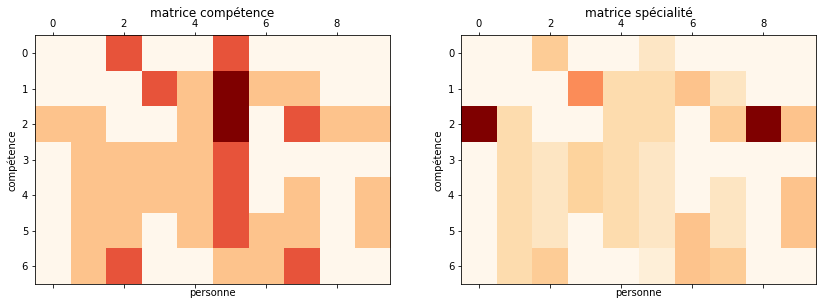

In [106]:
plt.figure(figsize=(14,7))
cmap = 'OrRd'
ax1 = plt.subplot(121,title='matrice compétence',xlabel='personne',ylabel='compétence')
ax1.matshow(matrice_competence,cmap=cmap)


ax2 = plt.subplot(122,title='matrice spécialité',xlabel='personne',ylabel='compétence')
ax2.matshow(matrice_specialite,cmap=cmap);

# Phase 1 : Application de la première politique

Soit une tâche T requérant la compétence C appartenant au projet PJ.

Dès lors que le niveau de compétence d'une personne P pour C est > 0 et que P est sur le projet PJ, alors elle pourra se voir assigner T.

### Formalisation du problème :

On écrit le problème sous la forme :


 $min \; c^Tx$ 

sous contrainte $Ax=b, \; x\geq 0.$

Politique =
0
DONNEES :

Charge totale de travail   : 312 h pour 50 tâches avec 7 compétences possibles. ( 6 h/tâche).
Disponibilités totales     : 364 h réparties sur 10 personnes ( 36 h/personne).
Approche choisie : la tâche doit être effectuée par la personne la plus compétente possible.

SORTIE :

Total heures non assignées : 22.0
Niveau moyen de spécialisation pour une heure travaillée : 0.96 / 3
Niveau moyen de spécialisation général : 0.43 / 3

Niveau moyen de compétence pour une heure travaillée     : 1.47 / 3
Niveau moyen de compétence général : 0.73 / 3
Sur 290 heures assignées, 290 le sont à des personnes impliquées dans le projet concerné.

Statut résolution : Optimization terminated successfully.
Méthode de résolution      : simplex
fonction objectif          : 1774.0
MESSAGE : CERTAINES HEURES N'ONT PU ETRE ASSIGNEES. SOUHAITEZ-VOUS CONTINUER AVEC UNE POLITIQUE MOINS RESTRICTIVE ?


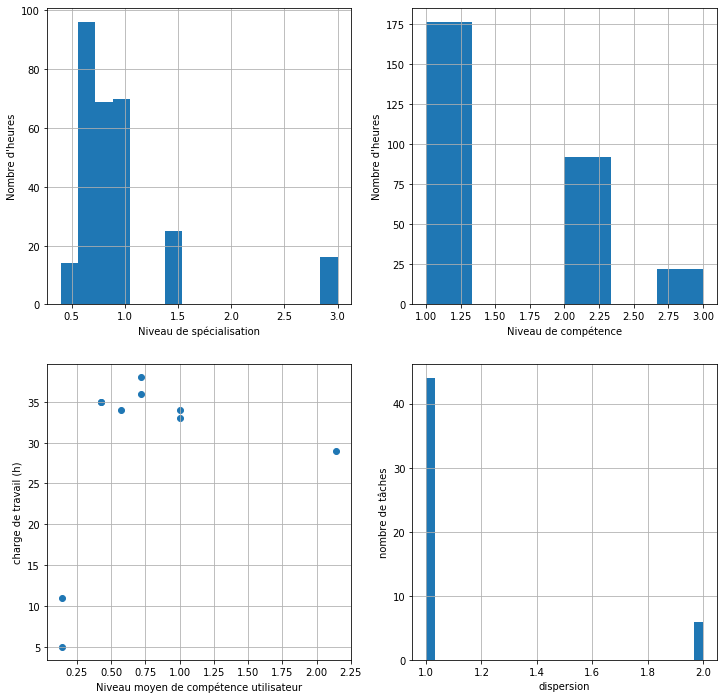

In [107]:
print('Politique =')
politique = int(input())

###### FORMLULATION #########
matrice_compromis = matrice_specialite * politique + (1-politique) * matrice_competence
arcs = []
costs = []        
for i in range(n_tasks):
    for j in range(n_people):
        if matrice_competence[competences[i],j] > 0 and  matrice_projet[projet_referent[i],j] == 1:
            arcs.append(tuple((i,j)))
            
            #détermination de l'utilité de l'assignation de la tache i à la personne j  :
            score = matrice_compromis[competences[i],j]
            costs.append(score)
            
            
# Chaque tâche à également la possibilité de ne pas être assignée, ce qui est fortement pénalisé.
for i in range(n_tasks):
    arcs.append(tuple((i,'not assigned')))
    costs.append(-100)
    
costs += [0] * n_people  #slack variables
costs = np.array(costs)
n_arcs = len(arcs)

A = np.zeros((n_tasks + n_people , n_arcs + n_people ))
b = np.zeros(n_tasks + n_people)

#equality constraints :
for i in range(n_tasks):
    for j in range(n_arcs):
        if arcs[j][0] == i :
            A[i,j] = 1
    b[i] = durations[i]
    
# inequality contraints:
for i in range(n_people):
    for j in range(n_arcs):
        if arcs[j][1] == i:
            A[i + n_tasks, j] = 1 
    A[i + n_tasks, n_arcs + i ] = 1    #slack variable
    b[i + n_tasks] = max_capacity[i]

###### RESOLUTION #########

method1 = 'simplex'
method2 ='interior-point'
method = method1
from scipy.optimize import linprog

l = linprog(-costs,A_eq=A,b_eq=b,method=method,options={'maxiter':1500})
if l.status !=0 :
    method = method2
    l = linprog(-costs,A_eq=A,b_eq=b,method=method,options={'maxiter':1500})
    
#print('\n\t',l.message,)

###### ETUDE #########

charges_utilisateurs = np.zeros(n_people)
for i in range(n_people ):
    for j in range(len(arcs)):
        if arcs[j][1] == i :
            charges_utilisateurs[i] += l.x[j]
            
lvl_moy = []
for i in range(n_people):
    niveaux = []
    temps = []
    for j in range(len(arcs)):
        if arcs[j][1] == i and l.x[j] > 0 :
            temps.append(l.x[j])
            tache_id = arcs[j][0]
            competence_id = competences[tache_id]
            niveaux.append(matrice_competence[competence_id,i])
    if np.sum(temps) > 0 :
        lvl_moy.append(np.vdot(temps,niveaux)/np.sum(temps))
mean_level = np.round(np.mean(lvl_moy),2)


lvl_moy = []
lvl_moy2 = []
lvl_moy_specialite = []
lvl_moy_specialite2 = []
temps = []
for i in range(n_people):
    niveaux,niveaux_specialites = [],[]
    tmp_temps = []
    for j in range(len(arcs)):
        if arcs[j][1] == i and l.x[j] > 0 :
            tmp_temps.append(l.x[j])
            tache_id = arcs[j][0]
            competence_id = competences[tache_id]
            niveaux_specialites.append(matrice_specialite[competence_id,i])
            niveaux.append(matrice_competence[competence_id,i])
            lvl_moy_specialite2 += int(l.x[j]) * [matrice_specialite[competence_id,i]]
            lvl_moy2 += int(l.x[j]) * [matrice_competence[competence_id,i]]
    if np.sum(tmp_temps) > 0 :
        temps.append(np.sum(tmp_temps))
        lvl_moy.append(np.vdot(tmp_temps,niveaux)/np.sum(tmp_temps))
        lvl_moy_specialite.append(np.vdot(tmp_temps,niveaux_specialites)/np.sum(tmp_temps))
    else :
        temps.append(0)
        lvl_moy.append(0)
        lvl_moy_specialite.append(0)
mean_level = np.round(np.vdot(temps,lvl_moy)/np.sum(temps),2)
mean_level_specialite = np.round(np.vdot(temps,lvl_moy_specialite)/np.sum(temps),2)
    
heure_projet = 0
for j in range(len(arcs)):
    if np.round(l.x[j],2) > 0 :
        tache_id = arcs[j][0]
        projet_id = projet_referent[tache_id]
        personne_id = arcs[j][1]
        if personne_id != 'not assigned' and  matrice_projet[projet_id,personne_id] == 1:
            heure_projet += l.x[j]
heure_projet = np.round(heure_projet)

h_NA=0
for j in range(len(arcs)):
    if arcs[j][1] =='not assigned' and l.x[j] > 0 :
            h_NA += np.round(l.x[j],2)
            
print("DONNEES :")       
print('\nCharge totale de travail   :',int(durations.sum()),'h pour',n_tasks,'tâches avec',
      n_competences,'compétences possibles.','(',int(durations.sum()/n_tasks),'h/tâche).')
print('Disponibilités totales     :',int(max_capacity.sum()),'h réparties sur',n_people,'personnes',
     '(',int(max_capacity.sum()/n_people),'h/personne).')

if politique == 0:
    print('Approche choisie : la tâche doit être effectuée par la personne la plus compétente possible.')
else :
    print('Approche choisie : la tâche doit être effectuée par la personne la plus spécialisée possible.')

print("\nSORTIE :")    
print('\nTotal heures non assignées :',h_NA)

print('Niveau moyen de spécialisation pour une heure travaillée :',mean_level_specialite,'/ 3')
print('Niveau moyen de spécialisation général :',np.round(matrice_specialite.mean(),2),'/ 3')

print('\nNiveau moyen de compétence pour une heure travaillée     :',mean_level,'/ 3')
print('Niveau moyen de compétence général :',np.round(matrice_competence.mean(),2),'/ 3')
print("Sur", int(durations.sum() - h_NA),'heures assignées,',
      int(np.round(heure_projet)),'le sont à des personnes impliquées dans le projet concerné.')

print('\nStatut résolution :',l.message)
print('Méthode de résolution      :',method)
print('fonction objectif          :',l.fun)

if h_NA > 0 :
    print("MESSAGE : CERTAINES HEURES N'ONT PU ETRE ASSIGNEES. SOUHAITEZ-VOUS CONTINUER AVEC UNE POLITIQUE MOINS RESTRICTIVE ?")

                
dispersion = np.zeros(n_tasks)
for i in range(n_tasks):
    for j in range(len(arcs)):
        if arcs[j][0] == i and np.round(l.x[j]) > 0 :
            dispersion[i] += 1
            
niveaux_specialite = np.unique(matrice_specialite)
density = np.zeros(niveaux_specialite.shape)
for j in range(len(arcs)):
    if np.round(l.x[j]) > 0 and arcs[j][1] !='not assigned' :
        tache_id, personne_id  = arcs[j]
        competences[tache_id]
        niveau_specialite = matrice_specialite[competence_id,personne_id]
        index = np.where(niveaux_specialite == niveau_specialite)[0][0]
        density[index] += l.x[j]


plt.figure(figsize=(12,12))
plt.subplot(223)
plt.grid()

plt.scatter(np.mean(matrice_competence,axis= 0) ,
            np.floor(charges_utilisateurs))
           
plt.xlabel('Niveau moyen de compétence utilisateur')
plt.ylabel('charge de travail (h)');


plt.subplot(222)
plt.grid()
#plt.plot(max_capacity,max_capacity,zorder=-1,c='cyan',label='y=x')
#plt.legend()
#plt.scatter(max_capacity,np.floor(charges_utilisateurs))          
plt.xlabel('Niveau de compétence')
plt.ylabel("Nombre d'heures");
plt.hist(lvl_moy2,bins=6)


plt.subplot(221)
plt.grid(zorder=-1)
plt.hist(lvl_moy_specialite2,bins=len(np.unique(lvl_moy_specialite2))*2,zorder=1);
plt.xlabel('Niveau de spécialisation')
plt.ylabel("Nombre d'heures")

plt.subplot(224)
plt.grid()
plt.hist(dispersion,bins=30)
plt.xlabel('dispersion')
plt.ylabel('nombre de tâches');

In [108]:
df1 = pd.DataFrame()
for j in range(len(arcs)):
    if l.x[j] > 0 :
        arc = arcs[j]
        df1 = df1.append(pd.DataFrame({'ID Task':[arc[0]],'ID User':[arc[1]],'Durée (h)':[l.x[j]]}))  
df1.reset_index(drop=True,inplace=True)  

## La répartition du travail :

In [120]:
df1

,ID Task,ID User,Durée (h)
0,1,5,4.0
1,2,6,11.0
2,3,4,7.0
3,4,1,5.0
4,5,6,7.0
5,6,7,7.0
6,7,5,8.0
7,8,2,4.0
8,8,7,3.0
9,9,5,6.0


# Phase 2 : Application de la seconde politique (pas systématique)

Si la première phase à laisser des heures de travail non assignées, on applique cette seconde politique moins restrictive.

Soit une tâche T requérant la compétence C appartenant au projet PJ.

Dès lors que le niveau de compétence d'une personne P pour C est > 0, alors elle pourra se voir assigner T.

### Formalisation du problème :

On écrit le problème sous la forme :


 $min \; c^Tx$ 

sous contrainte $Ax=b, \; x\geq 0.$

In [111]:
max_capacity2 = max_capacity - charges_utilisateurs
max_capacity2

decharges_taches = np.zeros(n_tasks)

for j in range(len(arcs)):
    if arcs[j][1] != 'not assigned':
        id_tache = arcs[j][0]
        decharges_taches[id_tache] += l.x[j]
decharges_taches

durations2 = durations - decharges_taches
durations2

taches_restantes = np.where(durations2 > 0)[0]
taches_restantes
durations_restantes = durations2[taches_restantes]

taches_restantes,durations_restantes

personnes_restantes = np.where(max_capacity2 > 0)[0]
max_capacity_restantes = max_capacity2[personnes_restantes]
personnes_restantes,max_capacity_restantes

n_people_restantes = len(personnes_restantes)
n_tasks_restantes = len(taches_restantes)


	 Optimization terminated successfully.

Charge totale de travail   : 22 h pour 5 tâches
Disponibilités totales     : 74 h réparties sur 3 personnes
Total heures non assignées : 20.0
Méthode de résolution      : simplex
fonction objectif          : 1996.0
Niveau moyen de compétence pour une heure travaillée : 2.0 / 3
Niveau moyen de compétence général : 0.73 / 3


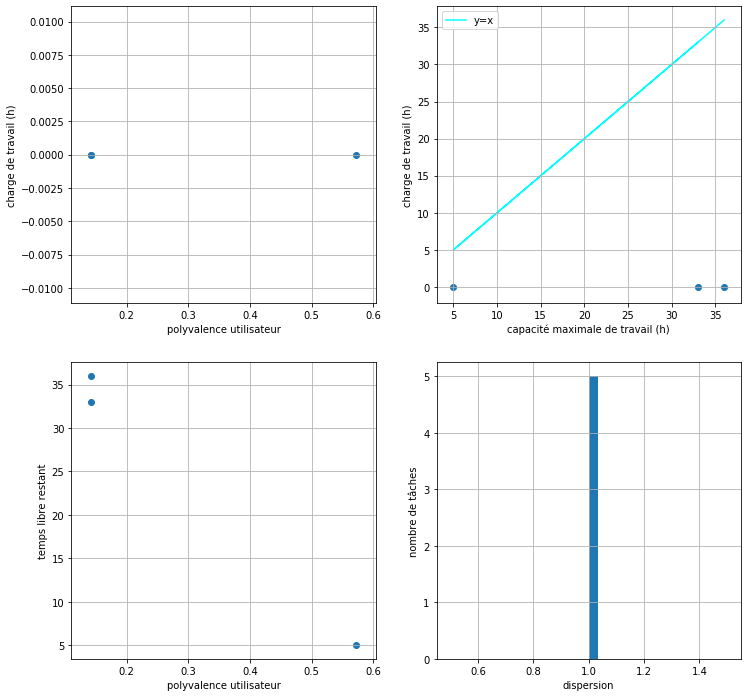

In [114]:
###### FORMULATION #########
arcs2 = []
costs2 = []        
for i in range(n_tasks_restantes):
    for j in range(n_people_restantes):
        if matrice_competence[competences[taches_restantes[i]], personnes_restantes[j]] > 0 :
            arcs2.append(tuple((taches_restantes[i],personnes_restantes[j])))
            score = matrice_compromis[competences[taches_restantes[i]], personnes_restantes[j]]
            costs2.append(score)
            
# Chaque tâche à également la possibilité de ne pas être assignée, ce qui est fortement pénalisé.
for i in range(n_tasks_restantes):
    arcs2.append(tuple((taches_restantes[i],'not assigned')))
    costs2.append(-100)
    
costs2 += [0] * (n_people_restantes)  #slack variables
costs2 = np.array(costs2)
n_arcs2 = len(arcs2)

A2 = np.zeros((n_tasks_restantes + n_people_restantes , n_arcs2 + n_people_restantes))
b2 = np.zeros(n_tasks_restantes + n_people_restantes)            


#equality constraints :
for i in range(n_tasks_restantes):
    for j in range(n_arcs2):
        if arcs2[j][0] == taches_restantes[i] :
            A2[i,j] = 1
    b2[i] = durations_restantes[i]
    
# inequality contraints:
for i in range(n_people_restantes):
    for j in range(n_arcs2):
        if arcs2[j][1] == personnes_restantes[i]:
            A2[i + n_tasks_restantes, j] = 1 
    A2[i + n_tasks_restantes, n_arcs2 + i ] = 1    #slack variable
    b2[i + n_tasks_restantes] = max_capacity_restantes[i]
 

###### RESOLUTION #########
method1 = 'simplex'
method2 ='interior-point'
method = method1
from scipy.optimize import linprog

l2 = linprog(-costs2,A_eq=A2,b_eq=b2,method=method,options={'maxiter':1500})
if l2.status !=0 :
    method = method2
    l2 = linprog(-costs2,A_eq=A2,b_eq=b2,method=method,options={'maxiter':1500})

print('\n\t',l2.message)

###### ETUDE #########    
h_NA=0
for j in range(len(arcs2)):
    if arcs2[j][1] =='not assigned' and l2.x[j] > 0 :
            h_NA += np.round(l2.x[j],2)
            
charges_utilisateurs_restantes = np.zeros(n_people_restantes)
for i in range(n_people_restantes):
    for j in range(len(arcs2)):
        if arcs[j][1] == personnes_restantes[i] :
            charges_utilisateurs_restantes[i] += l2.x[j]

lvl_moy = []
temps = []
for i in range(n_people_restantes):
    niveaux = []
    tmp_temps = []
    for j in range(len(arcs2)):
        if arcs2[j][1] == personnes_restantes[i] and l2.x[j] > 0 :
            tmp_temps.append(l2.x[j])
            tache_id = arcs2[j][0]
            competence_id = competences[tache_id]
            niveaux.append(matrice_competence[competence_id,personnes_restantes[i]])
    if np.sum(tmp_temps) > 0 :
        temps.append(np.sum(tmp_temps))
        lvl_moy.append(np.vdot(tmp_temps,niveaux)/np.sum(tmp_temps))
mean_level = np.round(np.vdot(temps,lvl_moy)/np.sum(temps),2)

print('\nCharge totale de travail   :',int(durations_restantes.sum()),'h pour',n_tasks_restantes,'tâches')
print('Disponibilités totales     :',int(max_capacity_restantes.sum()),'h réparties sur',n_people_restantes,'personnes')
print('Total heures non assignées :',h_NA)
print('Méthode de résolution      :',method)
print('fonction objectif          :',l2.fun)
print('Niveau moyen de compétence pour une heure travaillée :',mean_level,'/ 3')
print('Niveau moyen de compétence général :',np.round(matrice_competence.mean(),2),'/ 3')
                
dispersion = np.zeros(n_tasks_restantes)
for i in range(n_tasks_restantes):
    for j in range(len(arcs2)):
        if arcs2[j][0] == taches_restantes[i] and np.round(l2.x[j]) > 0 :
            dispersion[i] += 1



plt.figure(figsize=(12,12))
plt.subplot(221)
plt.grid()

plt.scatter(np.mean(matrice_competence[:,personnes_restantes],axis= 0) ,
            np.floor(charges_utilisateurs_restantes))
           
plt.xlabel('polyvalence utilisateur')
plt.ylabel('charge de travail (h)');
plt.subplot(222)
plt.grid()
plt.plot(max_capacity_restantes,max_capacity_restantes,zorder=-1,c='cyan',label='y=x')
plt.legend()
plt.scatter(max_capacity_restantes,
            np.floor(charges_utilisateurs_restantes))
           
plt.xlabel('capacité maximale de travail (h)')
plt.ylabel('charge de travail (h)');

plt.subplot(223)
plt.grid()
plt.scatter(np.mean(matrice_competence[:,personnes_restantes],axis=0),
            np.abs(np.floor(charges_utilisateurs_restantes - max_capacity_restantes)))
plt.xlabel('polyvalence utilisateur')
plt.ylabel('temps libre restant');

plt.subplot(224)
plt.grid()
plt.hist(dispersion,bins=30)
plt.xlabel('dispersion')
plt.ylabel('nombre de tâches');

## La deuxième répartition du travail :

In [119]:
df2 = pd.DataFrame()
for j in range(len(arcs2)):
    if l2.x[j] > 0 :
        arc = arcs2[j]
        df2 = df2.append(pd.DataFrame({'ID Task':[arc[0]],'ID User':[arc[1]],'Durée (h)':[l2.x[j]]}))  
df2.reset_index(drop=True,inplace=True)  
df2

,ID Task,ID User,Durée (h)
0,6,3,2.0
1,0,not assigned,3.0
2,34,not assigned,10.0
3,35,not assigned,3.0
4,43,not assigned,4.0
